In [1]:
import sys

sys.path.append("../src/")
import make_camera_coordinates as mcc
import vectorized_trajectory as vt
import project_points as pp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from brutils import pdutils as pdu
%matplotlib inline
import logging
from ipywidgets import IntSlider, FloatSlider, interact

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:


camera_pos = (0, 4, -100)
lookat_pos = (0,4,0)
ball_start = (0, 4)
ball_velocity_mph= 80
ball_launch_angle_deg = 1



In [51]:

## camera coordinates
CONVERSION_FACTOR = 0.3048

def point_to_rng(x, y, z):
    return [
        (x, x, 1), (y, y, 1), (z, z, 1)
    ]

# camera constants for the iphone
f  = 4.11/1000.
W = 4.8/1000.
H = 3.6 / 1000.   # http://photoseek.com/2013/compare-digital-camera-sensor-sizes-full-frame-35mm-aps-c-micro-four-thirds-1-inch-type/

# from video: look at distance_calculation.xlsm 
f  = 1.92/1000.
W = 1882.88/1000./1000.  #micrometers
H = 1059.12 / 1000./1000. #micrometers



c_dim = np.array([W, H])
resolution = np.array([1280, 720],dtype='float64')
baseball_diameter = 74.68 # mm 
baseball_diameter_m = baseball_diameter * 0.001

#ball_size_ratio = .5 * f / xy / c_dim * resolution

distance_to_size = lambda ft: (baseball_diameter_m / 2.) * f / (ft*CONVERSION_FACTOR) * 679809.65329708
distance_to_size_m = lambda m: (baseball_diameter_m / 2.) * f / m * 679809.65329708

def ball_size(distance, diameter=baseball_diameter_m):
    xy = (diameter / 2.) * (f / distance)
    print(xy)
    pct_scr = xy / c_dim
    print(pct_scr)
    pixels = pct_scr * resolution
    print(pixels)
    return pixels
    
divider = c_dim * resolution

def make_pic(x,y, resolution = resolution, size=5):
    # TODO: Draw an arrow if it is off the screen
    res = np.zeros(shape=(resolution[1], resolution[0]))
    res[y-size:y+size, x-size:x+size] = 1
    return res.astype('uint8')

ball_size(30*CONVERSION_FACTOR).astype(int)

7.840419947506561e-06
[ 0.00416406  0.00740277]
[ 5.32999317  5.32999317]


array([5, 5])

10
(1, 240, 1, 1, 2)
4


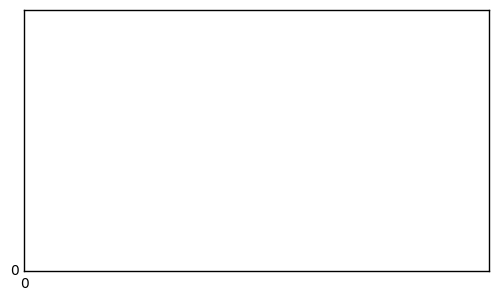

In [54]:
def get_conf(y0_ft, v0_mph, launch_angle_deg):
    ball_conf = {"GRID_SPEC": 
            [
                {"name": "y0", "spec":[y0_ft, y0_ft, 1]},
                {"name": "v0", "spec":[v0_mph, v0_mph, 1]},
                {"name": "launch_angle", "spec":[launch_angle_deg, launch_angle_deg, 1]}
            ]}
    return vt.conditions_from_conf(ball_conf)

def to_visualize(cam_x, cam_y, cam_z, la_x, la_y, la_z, ball_y0, v0, launch_angle_deg, frame):
    
    # ball simulation
    initial_conditions = get_conf(ball_y0, v0, launch_angle_deg)
    initial_conditions['name'] = "nb"
    traj = vt.Trajectory(**initial_conditions)
    ball_data = traj.solve_n_steps(int(240*1), 1/240.)[:]
    # extrinsic matrix
    args_c, args_p = (point_to_rng(*p) for p in [(cam_x, cam_y, cam_z), (la_x, la_y, la_z)])
    C, P, ranges_C, ranges_P = mcc.gen_C_gen_P(args_c, args_p, conversion_factor=CONVERSION_FACTOR)
    EX = mcc.get_extrinsic_matrix(C,P)
    # project points
    pitch_points = pp.xy_to_xyz_homogenous(ball_data[:,:,1:3])
    camera_coordinates = np.tensordot(pitch_points, EX, axes=([2],[3]))
    distances_m = np.linalg.norm(camera_coordinates, axis=4, ord=2).astype('uint16')
    sizes = distance_to_size_m(distances_m)
    #print(distances)
    print(distances_m[0,frame,0,0])
    xy = camera_coordinates[:,:,:,:,0:2] * (f / camera_coordinates[:,:,:,:,2, np.newaxis])

    # length in terms of percent of screen
    pct_scr = xy / c_dim

    relative_pixels_from_center = (pct_scr * resolution)

    final = (relative_pixels_from_center + resolution/2).astype('uint16')
    print(final.shape)
    to_show = final[0,frame,0,0,:]
    size_to_show = sizes[0,frame,0,0].astype(int)
    print(size_to_show)
    plt.imshow(make_pic(to_show[0], to_show[1], resolution=(1280,720), size=size_to_show), cmap='Greys', origin = 'lower',)
    plt.xticks([0])
    plt.yticks([0])
    #return to_show

cam_x_widget = IntSlider(value=0, min=-50, max=100, step=1 )
cam_y_widget = IntSlider(value=4, min=0, max=6, step=1 )
cam_z_widget = IntSlider(value=-100, min=-200, max=-2, step=1 )
la_x_widget = IntSlider(value=0, min=-20, max=60, step=1 )
la_y_widget = IntSlider(value=6, min=-20, max=40, step=1 )
la_z_widget = IntSlider(value=0, min=0, max=0, step=1 )
ball_y0_widget = FloatSlider(value=6., min=4, max=7, step=0.2 )
ball_v0_widget = FloatSlider(value=60., min=30., max=105., step=0.2 )
launch_angle_widget = FloatSlider(value=1, min=-2, max=3., step=0.2 )
frame_widget = IntSlider(value=0, min=0, max=240, step=1)

_ = interact(to_visualize, cam_x=cam_x_widget, cam_y=cam_y_widget, cam_z=cam_z_widget,
        la_x=la_x_widget, la_y=la_y_widget, la_z=la_z_widget, ball_y0=ball_y0_widget,
        v0=ball_v0_widget, launch_angle_deg=launch_angle_widget, frame=frame_widget)

<function __main__.to_visualize>

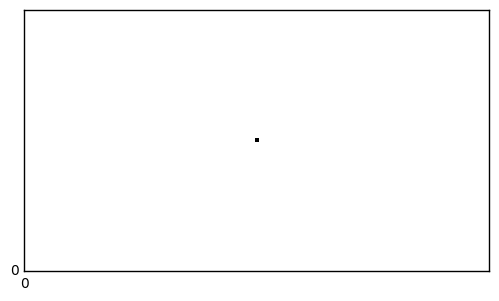

In [10]:

interact(to_visualize, cam_x=cam_x_widget, cam_y=cam_y_widget, cam_z=cam_z_widget,
        la_x=la_x_widget, la_y=la_y_widget, la_z=la_z_widget, ball_y0=ball_y0_widget,
        v0=ball_v0_widget, launch_angle_deg=launch_angle_widget, frame=frame_widget)

In [11]:
initial_conditions = get_conf(ball_start[1], ball_velocity_mph, ball_launch_angle_deg)
initial_conditions['name'] = "nb"
traj = vt.Trajectory(**initial_conditions)
ball_data = traj.solve_n_steps(int(240*1), 1/240.)[:]

In [23]:
ball_data.shape

(1, 240, 8)

In [13]:

## camera coordinates
CONVERSION_FACTOR = 0.3048

def point_to_rng(x, y, z):
    return [
        (x, x, 1), (y, y, 1), (z, z, 1)
    ]

args_c, args_p = (point_to_rng(*p) for p in [camera_pos, lookat_pos])
print(args_c)
print(args_p)

[(0, 0, 1), (4, 4, 1), (-100, -100, 1)]
[(0, 0, 1), (4, 4, 1), (0, 0, 1)]


In [15]:
C, P, ranges_C, ranges_P = mcc.gen_C_gen_P(args_c, args_p, conversion_factor=CONVERSION_FACTOR)

../src/gen_grid_points.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  cartesian(arrays[1:], out=out[0:m,1:])


In [19]:
EX = mcc.get_extrinsic_matrix(C,P)
EX

array([[[[  1.    ,  -0.    ,  -0.    ,  -0.    ],
         [  0.    ,   1.    ,  -0.    ,  -1.2192],
         [  0.    ,   0.    ,   1.    ,  30.48  ]]]])

In [30]:
## project the points
# camera constants for the iphone
f  = 4.11/1000.
W = 4.8/1000.
H = 3.6 / 1000.   # http://photoseek.com/2013/compare-digital-camera-sensor-sizes-full-frame-35mm-aps-c-micro-four-thirds-1-inch-type/
c_dim = np.array([W, H])
resolution = np.array([1280, 720],dtype='float64')

divider = c_dim * resolution
pitch_points = pp.xy_to_xyz_homogenous(ball_data[:,:,1:3])


In [66]:
pitch_points

array([[[  0.00000000e+00,   1.21920000e+00,   0.00000000e+00,
           1.00000000e+00],
        [  1.48990638e-01,   1.22171557e+00,   0.00000000e+00,
           1.00000000e+00],
        [  2.97979213e-01,   1.22406097e+00,   0.00000000e+00,
           1.00000000e+00],
        [  4.46963657e-01,   1.22623616e+00,   0.00000000e+00,
           1.00000000e+00],
        [  5.95943963e-01,   1.22824114e+00,   0.00000000e+00,
           1.00000000e+00],
        [  7.44920124e-01,   1.23007593e+00,   0.00000000e+00,
           1.00000000e+00],
        [  8.93892131e-01,   1.23174052e+00,   0.00000000e+00,
           1.00000000e+00],
        [  1.04285998e+00,   1.23323492e+00,   0.00000000e+00,
           1.00000000e+00],
        [  1.19182366e+00,   1.23455913e+00,   0.00000000e+00,
           1.00000000e+00],
        [  1.34078317e+00,   1.23571316e+00,   0.00000000e+00,
           1.00000000e+00],
        [  1.48973851e+00,   1.23669702e+00,   0.00000000e+00,
           1.00000000e+00],

In [68]:
camera_coordinates = np.tensordot(pitch_points, EX, axes=([2],[3]))
xy = camera_coordinates[:,:,:,:,0:2] * (f / camera_coordinates[:,:,:,:,2, np.newaxis])

# length in terms of percent of screen
pct_scr = xy / c_dim

relative_pixels_from_center = (pct_scr * resolution)

final = (relative_pixels_from_center + resolution/2).astype('uint16')
to_show = final[0,:,0,0,:]

num_frames = to_show.shape[0]


In [72]:
def make_pic(x,y, resolution = resolution, size=5):
    res = np.zeros(shape=(resolution[1], resolution[0]))
    res[y-size:y+size, x-size:x+size] = 1
    return res.astype('uint8')

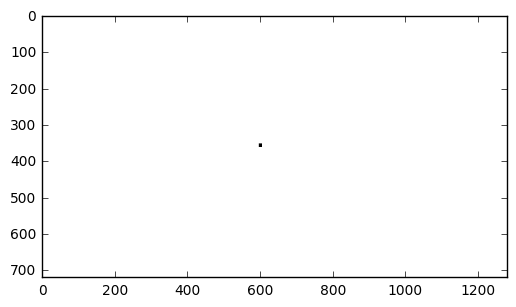

In [73]:
plt.imshow(make_pic(600, 358, resolution=(1280,720)), cmap='Greys')

In [62]:
make_pic(1,1, resolution=(8,3))

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [ ]:
plt.imshow()